## Proof of Concept



### Preface



This file is meant to basically check the sanity and correctness of
the data and code used to work out nutrition from household
expenditure data.

There are a few modules you may need to install:



In [2]:
#!pip install CFEDemands --upgrade
#!pip install xarray
#!pip install dvc[gdrive]
#!pip install h5netcdf

All the data required for estimation and calculation can be found
  in a google spreadsheet.  Choose one to explore!



In [1]:
COUNTRY = 'Nigeria'

In [2]:
URL = {'Uganda':'https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/',
       'Tanzania':'https://docs.google.com/spreadsheets/d/1Tknc2F8K6SaA7j0R7J_NE8yJBTsCPPw77_Bfc04MY40/',
       'ICRISAT':'https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo',
       'Nigeria':{'Expenditures':'https://docs.google.com/spreadsheets/d/1qzz6XGhPWLZLmwjrUY4W9k9U2PYukWblQKXWu0l37C4/',
                  'FCT':'https://docs.google.com/spreadsheets/d/1whE_EW5x-jxrsKvYWfefdBppzp_TZhPP61bdEN-FEJ4/',
                  'RDI':'https://docs.google.com/spreadsheets/d/1whE_EW5x-jxrsKvYWfefdBppzp_TZhPP61bdEN-FEJ4/',
                  'HH Characteristics':'https://docs.google.com/spreadsheets/d/1whE_EW5x-jxrsKvYWfefdBppzp_TZhPP61bdEN-FEJ4/',
                  'Prices':'https://docs.google.com/spreadsheets/d/1whE_EW5x-jxrsKvYWfefdBppzp_TZhPP61bdEN-FEJ4/'}
                  }
DAYS_PER_PERIOD = {'Uganda':7,'Tanzania':7,'ICRISAT':365.25,'Nigeria':7} # Number of days of expenditure recall

To read the various sheets, we&rsquo;ll need some credentials.  Point to an
unencrypted json file that has the appropriate permissions:



In [3]:
my_creds = '../students.json'

### Estimation



First, we pull in data on expenditures, household characteristics,
   and price:



In [4]:
import cfe
import numpy as np
from eep153_tools import read_sheets

x = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='Expenditures')

if len(x.columns==5): # stored as a series
    x = x.set_index(['j','t','m','i']).squeeze()
    x = x.unstack('i')
else:    
    x = x.set_index(['j','t','m'])
    x.columns.name = 'i'
    
x = x.replace(0,np.nan)
y = np.log(x)

z = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='HH Characteristics').set_index(['j','t','m'])
z.columns.name = 'k'

p = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='Prices').set_index(['t','m'])
p.columns.name = 'i'

/home/ligon/anaconda3/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


Let&rsquo;s take a look at the  different periods that appear in the
data. If you can&rsquo;t estimate (the next step) because your kernel dies
it may be that you should use a subset of the periods.



In [5]:
use_periods = "t in %s" % str(p.index.levels[0].tolist())

# If you want to use just a subset of periods, redefine
# use_periods here; e.g.,
#
#use_periods ="t in ['2015Q3','2016Q1','2018Q3','2019Q1']"

use_periods

"t in ['2010Q3', '2011Q1', '2012Q3', '2013Q1', '2015Q3', '2016Q1', '2018Q3', '2019Q1']"

Next, we construct an object we can use in the estimation.



In [6]:
r = cfe.Result(y=y.query(use_periods),
               z=z.query(use_periods),
               prices=p.query(use_periods))

Next, we estimate CFE demands *given* the prices and budgets of households in the data.



In [7]:
r.get_alpha()
xhat = r.get_predicted_expenditures()

Estimation is kind of expensive, so you might want to save these
results to use in your later code.



In [8]:
r.to_dataset("my %s.ds" % COUNTRY)

<xarray.Dataset>
Dimensions:           (i: 107, j: 8596, k: 15, kp: 15, m: 6, t: 8)
Coordinates:
  * i                 (i) <U36 'Apples' 'Avocado pear' ... 'Yam--roots'
  * j                 (j) int64 10001 10002 10003 10004 ... 379152 379154 379155
  * t                 (t) object '2010Q3' '2011Q1' ... '2018Q3' '2019Q1'
  * m                 (m) object 'North central' 'North east' ... 'South west'
  * k                 (k) <U10 'M 00-03' 'M 04-08' ... 'F 51+' 'log HHSize'
  * kp                (kp) <U10 'M 00-03' 'M 04-08' ... 'F 51+' 'log HHSize'
Data variables: (12/20)
    alpha             (i) float64 nan nan nan 4.682 6.02 ... 4.945 nan nan 5.638
    beta              (i) float64 nan nan nan 0.3095 ... 0.3372 nan nan 0.2653
    delta             (k, i) float64 nan nan nan 0.04389 ... nan nan 0.2686
    prices            (i, t, m) float64 nan nan nan nan ... 350.0 216.7 160.0
    characteristics   (k, j, t, m) float64 nan nan nan 0.0 ... nan nan nan nan
    loglambdas        (j, t, m) float64 nan nan nan -0.7557 ... nan nan nan nan
    ...                ...
    se_beta           object None
    se_alpha          (i) float64 0.0 0.0 0.0 0.02998 ... 0.0 0.0 0.02239
    se_a              (i, t, m) float64 nan nan nan ... 0.04663 0.05678 0.04618
    y                 (i, j, t, m) float64 nan nan nan nan ... nan nan nan nan
    logp              (i, t, m) float64 nan nan nan nan ... 5.858 5.378 5.075
    z                 (k, j, t, m) float64 nan nan nan 0.0 ... nan nan nan nan

In [6]:
r = cfe.from_dataset("my %s.ds" % COUNTRY)

xhat = r.get_predicted_expenditures()

/home/ligon/anaconda3/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


### Plotting Food Demands



Now we&rsquo;re interested in predicting what quantities of different
   kinds of food *would* have been, if something (e.g., a price,
   budget, household characteristics) was different.



#### Ceteris paribus



We begin by setting up some benchmarks for prices and budgets, so
   the things we don&rsquo;t want to change we can hold fixed.



In [9]:
import pandas as pd
r.get_beta(as_df=True).sort_values(ascending=False)

Milk powder         0.598504
Chocolate drinks    0.552311
Rice--local         0.463997
Sugar               0.446197
Eggs                0.445440
                      ...   
Soya beans               NaN
Sweet potatoes           NaN
Watermelon               NaN
Wild game meat           NaN
Yam flour                NaN
Name: beta, Length: 107, dtype: float64

In [13]:
### First year, first market, and some good.  Change if you wish! ###
my_t = r.coords['t'].data.flatten()[0]
my_m = r.coords['m'].data.flatten()[0]
#my_i = r.get_beta(as_df=True).sort_values(ascending=False).index[0]
my_i='Eggs'
#####################################################################

p = r.prices.sel(t=my_t,m=my_m,drop=True)
phat = p.to_dataframe('i').dropna()

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

So, we have a budget for median household at that time and place



In [14]:
xbar = r.get_predicted_expenditures().sum('i')
median_x = xbar.where(xbar>0).sel(t=my_t,m=my_m).median('j') # Budget (median household)

#### Plot demand schedule



/home/ligon/Research/CFEDemands/cfe/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.86E-09.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/home/ligon/Research/CFEDemands/cfe/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -1.86E-09.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/home/ligon/Research/CFEDemands/cfe/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -2.33E-10.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))
/home/ligon/Research/C

Text(0, 0.5, 'Price of Eggs')

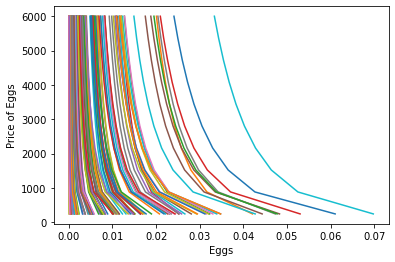

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# Values for prices
ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/5,ref_price*5,10)

for x in [median_x*s for s in [.5,1.,2]]:
    plt.plot([r.demands(x,my_prices(p0))[my_i] for p0 in P],P)

plt.xlabel(my_i)
plt.ylabel('Price of %s' % my_i)

### Plotting Nutrient Demands



The nutrient value of food consumed by the household is just the
   product of its diet and a food conversion table.  So let&rsquo;s write a
   function that describes that product:



In [25]:
# Get FCT:
fct = read_sheets(URL[COUNTRY],
                  json_creds='../students.json',
                  sheet='FCT').set_index('i')
fct.columns.name='n'

def nutrient_demand(x,p):
    c = r.demands(x,p,tol=1e-6)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

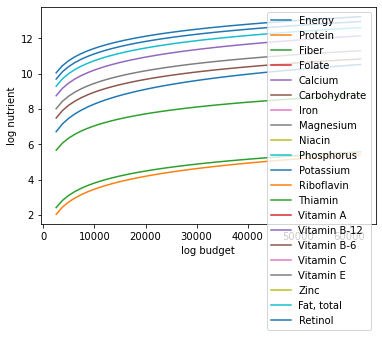

In [15]:
import numpy as np
import pandas as pd

### If you're getting lots of not useful warnings you want to ignore
# import warnings
# warnings.filterwarnings('ignore',category=UserWarning)
####################################################################

X = np.linspace(median_x/5,median_x*5,50)

# UseNutrients = ['Protein','Calories','Iron','Calcium']
UseNutrients = fct.columns.tolist()

plt.plot(X,pd.concat({x:np.log(nutrient_demand(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient')

### Nutritional requirements



Individuals have nutritional requirements established by nutrition
 scientists.  Here we grab one such set of requirements:



In [26]:
rdi = read_sheets(URL[COUNTRY],
                  json_creds='../students.json',
                  sheet='RDI').set_index('n').replace(np.nan,0)
rdi.columns.name = 'k'

rdi = rdi.replace('',0)
rdi

k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
Carbohydrate,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
Iron,7.0,7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
Magnesium,80.0,80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


#### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
    can&rsquo;t directly compare household level nutrition with individual
    level requirements.  What we **can** do is add up minimum individual
    requirements, and see whether household total exceed these.  This
    isn&rsquo;t a guarantee that all individuals have adequate nutrition
    (since the way food is allocated in the household might be quite
    unequal, or unrelated to individual requirements), but it is
    *necessary* if all individuals are to have adequate nutrition.

For the average household, the number of different kinds of people
can be computed by averaging over households:



In [27]:
# Find average household characteristics for reference period & place
zbar = r.z.sel(t=my_t,m=my_m,drop=True).mean('j').to_dataframe()

Now, the inner/dot/matrix product between `zbar` and the `rda`
 DataFrame of requirements will give us minimum requirements for the
 average household:



In [28]:
# This matrix product gives minimum nutrient requirements for average
# household in reference year & place
my_rdi,my_zbar = rdi.align(zbar.T,axis=1,join='inner')
hh_rdi = my_rdi@my_zbar.T

# But this is per *day*, while our data is per period:
hh_rdi = hh_rdi*DAYS_PER_PERIOD[COUNTRY]
hh_rdi

,z
n,
Energy,72641.309824
Protein,1593.804786
Fiber,1016.978338
Folate,13462.216625
Calcium,43979.219144
Carbohydrate,5488.652393
Iron,457.565491
Magnesium,11390.604534
Niacin,513.627204


#### Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
 and we&rsquo;ve computed minimum nutritional requirements for the average
 household, we can *normalize* nutritional intake to check the adequacy
 of diet.



In [29]:
def nutrient_adequacy_ratio(x,p):
    return (nutrient_demand(x,p)/hh_rdi.T).squeeze()

In terms of normalized nutrients, any household with more than one
 unit of any given nutrient (or zero in logs) will be consuming a
 minimally adequate level of the nutrient; below this level there&rsquo;s
 clearly nutritional inadequacy.  For this reason the ratio of
 actual nutrients to required nutrients is termed the &ldquo;nutrient
 adequacy ratio,&rdquo; or NAR.



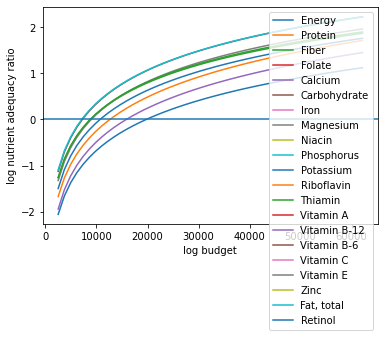

In [30]:
plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)

As before, we can also vary relative prices.  Here we trace out
 nutritional adequacy varying the price of a single good:



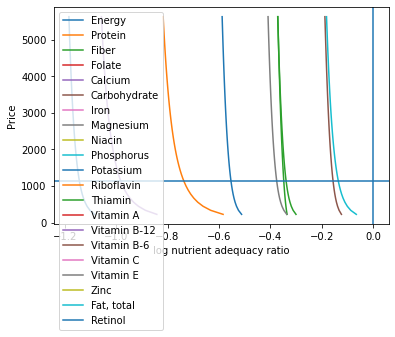

In [21]:
poorer_x = median_x/2

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(poorer_x,my_prices(p0,i=my_i)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.axhline(p.sel(i=my_i).values)